In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io as sio
from pyESN import ESN
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from copy import deepcopy

from data_mng import forecasting_data_split, memory_data_split

def simulate_error(x_train, y_train, x_test, y_test, scaling_param, SR_param
                   ,neuron_activation=0
                   ,num_sim=10):
    count = 0
    E_min = 100
    E_train_min = 100
    min_SR = None
    min_scal = None

    for SR in SR_param:
        #E_train = []
        #E_test = []
        #R2 = []
        #count += 1
        #print "SR ", SR

        for scaling in scaling_param:
            #print "scaling", scaling


            for sim in range(num_sim):
                mse_train = 0
                mse = 0
                r2 = 0

                esn = ESN(n_inputs=1,
                          n_outputs=1,
                          n_reservoir=1000,
                          spectral_radius=SR,
                          radius=1,
                          sparsity=0.0,
                          noise=0.,
                          input_scaling=scaling / np.std(x_train),
                          output_scaling=scaling / np.std(y_train),
                          transient=200,
                          reservoir_uniform=True,
                          regularization=0.01,
                          online_training=False,
                          learning_rate=0,
                          neuron_activation=neuron_activation,
                          leak_rate=1,
                          # random_state=seed,
                          output_feedback=False
                          # , wigner = True
                          )

                transient = 200
                esn.evolve(x_train, y_train)
                y_train_predicted = esn.train(y_train)

                y_predicted = esn.predict(x_test)

                mse_train += np.sqrt(mean_squared_error(y_train_predicted[transient:], y_train[ transient:])) / np.std(y_train)
                mse += np.sqrt(mean_squared_error(y_predicted, y_test)) / np.std(y_test)
                r2 += r2_score(y_predicted[:], y_test[:])

            #print (mse_train / num_sim)

            #E_train.append(mse_train / num_sim)
            #E_test.append(mse / num_sim)
            #R2.append(r2 / num_sim)

            # selected with the training error
            if mse_train / num_sim < E_train_min:
                #print mse_train, ' < ', E_train_min
                #print 'I WAS ', E_min, "NOW ", mse / num_sim
                E_train_min = mse_train / num_sim
                E_min = mse / num_sim
                min_SR = SR / num_sim
                min_scal = scaling / num_sim

        #plt.plot(E_test)

    #plt.show()

    return E_min, min_SR, min_scal

def y_nonlinear(signal, nu, tau):
    arg = np.zeros(len(signal))

    for i in range(len(signal)):
        arg[i] = signal[i - tau]

    return np.sin(nu * arg[:])


def nonlinear_task(data, nu, tau, train_len=500, test_len=200):
    NL_data = y_nonlinear(data, nu, tau)

    x_train = data[2 * tau:train_len] + 0
    y_train = NL_data[2 * tau:train_len] + 0

    x_test = data[train_len:train_len + test_len] + 0
    y_test = NL_data[train_len:train_len + test_len] + 0

    return x_train, y_train, x_test, y_test



def simulate_loss(x_train, 
                        y_train, 
                        x_test, 
                        y_test,
                        n_inputs=1,
                        n_outputs=1,
                        n_reservoir=1000,
                        spectral_radius=11,
                        sparsity=0.0,
                        noise=0.00,
                        scaling = 1,
                        transient=200 ,
                        reservoir_uniform=True,
                        regularization=0.0,
                        online_training=False,
                        learning_rate=0.1,
                        neuron_activation=6,
                        leak_rate=1,
                        random_state=None,
                        output_feedback=False,
                       radius = 10,
                  wigner = False
                        ):

    esn = ESN(n_inputs=n_inputs,
             n_outputs=n_outputs,
              n_reservoir=n_reservoir,
              spectral_radius=spectral_radius,
              sparsity= sparsity,
              noise=noise,
            input_scaling=scaling/np.std(x_test),
             output_scaling=scaling/np.std(y_test),
              transient=transient ,
              reservoir_uniform=reservoir_uniform,
              regularization=regularization,
              online_training=online_training,
              learning_rate=learning_rate,
             neuron_activation=neuron_activation,
              leak_rate=leak_rate,
             random_state=random_state,
              output_feedback=output_feedback,
             radius = radius,
             wigner = wigner)
    
    y_train_predicted = esn.fit(x_train, y_train)
    y_predicted = esn.predict(x_test)

    mse_train = np.sqrt(mean_squared_error(y_train_predicted[transient:], y_train[transient:]))/np.std(y_train)
    mse = np.sqrt(mean_squared_error(y_predicted, y_test) )/np.std(y_test)
    r2 = r2_score(y_predicted[:], y_test[:])
    
    return mse_train, mse, r2




def repeat_experiment(x_train, 
                        y_train, 
                        x_test, 
                        y_test,
                        activation,
                        spectral_radius,
                        scaling,
                      reps=10
                         ):
    E_train = []
    E_test = []
    R2 = []
    
    for _ in range(reps):
        e_train, e_test, r2 = simulate_loss(
                                    x_train, 
                                    y_train, 
                                    x_test, 
                                    y_test,
                                    n_reservoir=1000,
                                    spectral_radius=spectral_radius,
                                    transient=100 ,
                                    scaling = scaling,
                                    neuron_activation= activation,
                                    radius = 10,
                                    )
        E_train.append(e_train)
        E_test.append(e_test)
        R2.append(r2)
    
    E_train_mean = np.mean(E_train)
    E_train_std = np.std(E_train)
    E_test_mean = np.mean(E_test)
    E_test_std = np.std(E_test)
    R2_mean = np.mean(R2)
    R2_std = np.std(R2)
    
    return E_train_mean, E_train_std, E_test_mean, E_test_std, R2_mean, R2_std


#data = np.load('data/mackey_glass_t17.npy')
#data = sio.loadmat('data/MG5k.mat')['MG5k']
#data = sio.loadmat('data/MG.mat')['signal']
#data = np.loadtxt('data/MSO_3freq')
#data = np.loadtxt('data/square_wave')
#data = np.loadtxt('data/lorenz.dat')
#data = np.loadtxt('data/henon.dat')
#data = np.loadtxt('data/rossler.dat')
data = np.loadtxt('data/laser_long.dat')
#data = np.loadtxt('data/light_curve.dat')
#data = np.loadtxt('data/sunspot_M')
#data = 2*np.random.rand(10000)-1

data_len = data.shape[0]
train_len = 6000
test_len = 2000


param = range(0,100,5)
reps = 1

print "doing spherical"
# n = normalized (spherical)
E_test_n = []
V_test_n = []
E_train_n = []
V_train_n = []
r2_n = []
V_r2_n = []



for i in param:
    k_steps_behind = i
    x_train, y_train, x_test, y_test = memory_data_split(data, train_len, test_len,k_steps_behind)
    
    
    train, train_std, test, test_std, r2, r2_std = repeat_experiment(x_train, 
                        y_train, 
                        x_test, 
                        y_test,
                        activation=5,
                        spectral_radius=15,
                        scaling=0.01,
                      reps=reps
                         )
    E_train_n.append(train)
    V_train_n.append(train_std)
    E_test_n.append(test)
    V_test_n.append(test_std)
    r2_n.append(r2)
    V_r2_n.append(r2_std)
    
E_test_n = np.array(E_test_n)
V_test_n = np.array(V_test_n)
E_train_n = np.array(E_train_n)
V_train_n = np.array(V_train_n)
r2_n = np.array(r2_n )
V_r2_n = np.array(V_r2_n)

print "doing regular"
#s = standard (REGULAR!)
E_test_s = []
V_test_s = []
E_train_s = []
V_train_s = []
r2_s = []
V_r2_s = []


for i in param:
    k_steps_behind = i
    x_train, y_train, x_test, y_test = memory_data_split(data, train_len, test_len,k_steps_behind)
    
    
    train, train_std, test, test_std, r2, r2_std = repeat_experiment(x_train, 
                        y_train, 
                        x_test, 
                        y_test,
                        activation=0,
                        spectral_radius=0.5,
                        scaling=1,
                      reps=reps
                         )
    E_train_s.append(train)
    V_train_s.append(train_std)
    E_test_s.append(test)
    V_test_s.append(test_std)
    r2_s.append(r2)
    V_r2_s.append(r2_std)
    
E_test_s = np.array(E_test_s)
V_test_s = np.array(V_test_s)
E_train_s= np.array(E_train_s)
V_train_s = np.array(V_train_s)
r2_s = np.array(r2_s )
V_r2_s = np.array(V_r2_s)

print "doing linear"
# l = linear
E_test_l = []
V_test_l = []
E_train_l = []
V_train_l = []
r2_l = []
V_r2_l = []



for i in param:
    k_steps_behind = i
    x_train, y_train, x_test, y_test = memory_data_split(data, train_len, test_len,k_steps_behind)
    
    
    train, train_std, test, test_std, r2, r2_std = repeat_experiment(x_train, 
                        y_train, 
                        x_test, 
                        y_test,
                        activation=7,
                        spectral_radius=0.95,
                        scaling=1,
                      reps=reps
                         )
    E_train_l.append(train)
    V_train_l.append(train_std)
    E_test_l.append(test)
    V_test_l.append(test_std)
    r2_l.append(r2)
    V_r2_l.append(r2_std)
    
E_test_l = np.array(E_test_l)
V_test_l = np.array(V_test_l)
E_train_l= np.array(E_train_l)
V_train_l = np.array(V_train_l)
r2_l = np.array(r2_l)
V_r2_l = np.array(V_r2_l)



# np.savez('data_WN',
#         E_test_n = E_test_n,
#         V_test_n = V_test_n,
#         E_train_n = E_train_n,
#         V_train_n = V_train_n,
#         r2_n = r2_n,
#         V_r2_n = V_r2_n,
#         E_test_s = E_test_s,
#         V_test_s = V_test_s,
#         E_train_s = E_train_s,
#         V_train_s = V_train_s,
#         r2_s = r2_s,
#         V_r2_s = V_r2_s,
#         E_test_l = E_test_l,
#         V_test_l = V_test_l,
#         E_train_l = E_train_l,
#         V_train_l = V_train_l,
#         r2_l = r2_l,
#         V_r2_l = V_r2_l,
#         )


fig, ax1 = plt.subplots(figsize = (15,8))
plt.tight_layout()
#ax2 = ax1.twinx()
param = np.array(param)

ax1.set_xlabel("timesteps")
ax1.plot(param,E_test_n, 'b', label = 'spherical_test')
ax1.fill_between(param, E_test_n-V_test_n, E_test_n+V_test_n,color='b', alpha=0.2 )
ax1.plot(param, E_train_n,'b--', label = 'SNACT_train')
ax1.fill_between(param, E_train_n-V_train_n, E_train_n+V_train_n,color='b', alpha=0.2 )

ax1.plot(param,E_test_s , 'r', label = 'regular_test')
ax1.fill_between(param, E_test_s-V_test_s, E_test_s+V_test_s,color='r', alpha=0.2 )
ax1.plot(param,E_train_s , 'r--', label = 'regular_train')
ax1.fill_between(param, E_train_s-V_train_s, E_train_s+V_train_s,color='r', alpha=0.2 )

ax1.plot(param,E_test_l , 'g', label = 'linear_test')
ax1.fill_between(param, E_test_l-V_test_l, E_test_l+V_test_l,color='g', alpha=0.2 )
ax1.plot(param,E_train_l , 'g--', label = 'linear_train')
ax1.fill_between(param, E_train_l-V_train_l, E_train_l+V_train_l,color='g', alpha=0.2 )


ax1.set_ylabel("NMSE")
ax1.legend(loc="best")

# #ax2.plot(param, r2_n, 'b.', label = 'spherical')
# ax2.errorbar(param, r2_n, yerr=V_r2_n, fmt='o', color='b', ecolor='b', elinewidth=1, capsize=1,label = 'spherical');
# ax2.errorbar(param, r2_s, yerr=V_r2_n, fmt='o', color='r', ecolor='r', elinewidth=1, capsize=1,label = 'regular' );
# ax2.errorbar(param, r2_l, yerr=V_r2_n, fmt='o', color='g', ecolor='g', elinewidth=1, capsize=1,label ='linear' );


# #ax2.plot(param, r2_s, 'r.', label = 'regular')
# #ax2.plot(param, r2_l, 'g.', label = 'linear')
# ax2.set_ylabel("R2")
# ax2.legend(loc="best")



plt.title("Memory - WN")
#plt.savefig("Memory-WN.pdf", format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.05)
#plt.show()


doing spherical
doing regular


Populating the interactive namespace from numpy and matplotlib


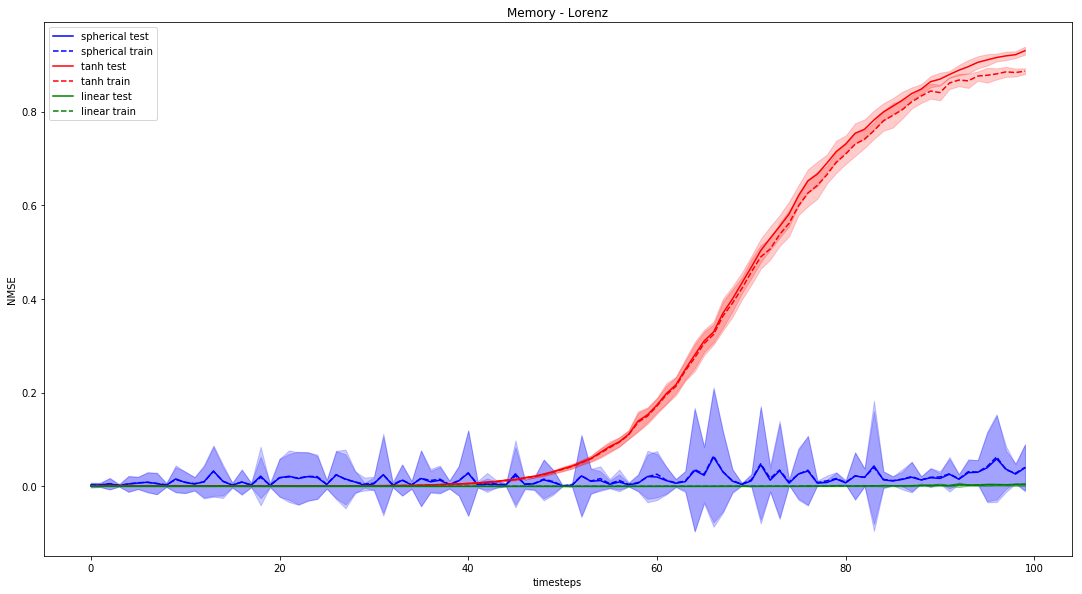

In [4]:
%pylab inline

param = range(0,100,1)

D = np.load('data_lorenz.npz')


fig, ax1 = plt.subplots(figsize = (15,8))
plt.tight_layout()
#ax2 = ax1.twinx()
param = np.array(param)



ax1.set_xlabel("timesteps")
ax1.plot(param, D['E_test_n'], 'b', label = 'spherical test')
ax1.fill_between(param, D['E_test_n']-D['V_test_n'], D['E_test_n']+D['V_test_n'],color='b', alpha=0.2 )
ax1.plot(param, D['E_train_n'],'b--', label = 'spherical train')
ax1.fill_between(param, D['E_train_n']-D['V_train_n'], D['E_train_n']+D['V_train_n'],color='b', alpha=0.2 )

ax1.plot(param, D['E_test_s'] , 'r', label = 'tanh test')
ax1.fill_between(param,D['E_test_s']-D['V_test_s'], D['E_test_s']+D['V_test_s'],color='r', alpha=0.2 )
ax1.plot(param,D['E_train_s'] , 'r--', label = 'tanh train')
ax1.fill_between(param, D['E_train_s']-D['V_train_s'], D['E_train_s']+D['V_train_s'],color='r', alpha=0.2 )

ax1.plot(param, D['E_test_l'] , 'g', label = 'linear test')
ax1.fill_between(param, D['E_test_l']-D['V_test_l'], D['E_test_l']+D['V_test_l'],color='g', alpha=0.2 )
ax1.plot(param,D['E_train_l'] , 'g--', label = 'linear train')
ax1.fill_between(param, D['E_train_l']-D['V_train_l'], D['E_train_l']+D['V_train_l'],color='g', alpha=0.2 )


ax1.set_ylabel("NMSE")
ax1.legend(loc="best")

# #ax2.plot(param, r2_n, 'b.', label = 'spherical')
# ax2.errorbar(param, r2_n, yerr=V_r2_n, fmt='o', color='b', ecolor='b', elinewidth=1, capsize=1,label = 'spherical');
# ax2.errorbar(param, r2_s, yerr=V_r2_n, fmt='o', color='r', ecolor='r', elinewidth=1, capsize=1,label = 'regular' );
# ax2.errorbar(param, r2_l, yerr=V_r2_n, fmt='o', color='g', ecolor='g', elinewidth=1, capsize=1,label ='linear' );


# #ax2.plot(param, r2_s, 'r.', label = 'regular')
# #ax2.plot(param, r2_l, 'g.', label = 'linear')
# ax2.set_ylabel("R2")
# ax2.legend(loc="best")



plt.title("Memory - Lorenz")
#plt.savefig("Memory-Laser.pdf", format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.05)
plt.show()



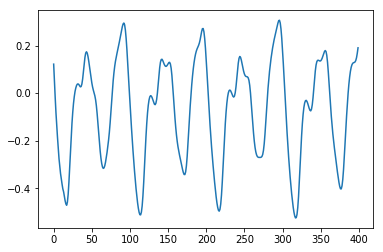

In [30]:
data = np.load('data/mackey_glass_t17.npy')
data1 = data/np.std(data)
plot(data[:400])
#plot(data1[:400])

In [39]:
for i in param:
    k_steps_behind = i
    x_train, y_train, x_test, y_test = memory_data_split(data, train_len, test_len,k_steps_behind)
    
    
    train, train_std, test, test_std, r2, r2_std = repeat_experiment(x_train, 
                        y_train, 
                        x_test, 
                        y_test,
                        activation=5,
                        spectral_radius=15,
                        scaling=0.01,
                      reps=reps
                         )
    E_train_n.append(train)
    V_train_n.append(train_std)
    E_test_n.append(test)
    V_test_n.append(test_std)
    r2_n.append(r2)
    V_r2_n.append(r2_std)
    
E_test_n = np.array(E_test_n)
V_test_n = np.array(V_test_n)
E_train_n = np.array(E_train_n)
V_train_n = np.array(V_train_n)
r2_n = np.array(r2_n )
V_r2_n = np.array(V_r2_n)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

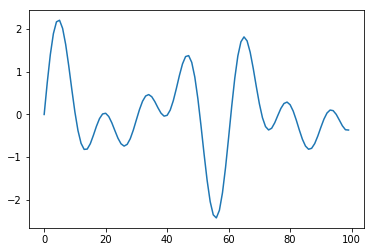